This tutorial reproduces the results of Tutorial 6 on spinw.org. It is a ferromagnetic kagome lattice. The interactions go upto 5th neighbour.


Get Packages

In [1]:
using Sunny, GLMakie, CairoMakie 

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. Space group is P-3 or 147. Sunny can use the space group symmetry to generate the rest of the atoms in the cell when the first position is specified. Here Cu+ atoms have spin = 1. The supercell is (2,2,1).

In [2]:
a=6.0
b=6.0
c=8.0

latvecs = lattice_vectors(a, b, c, 90, 90, 120) 
positions=[[1/2, 0, 0]]
types=["Cu1"]
Cu = Crystal(latvecs,positions,147;types)
view_crystal(Cu)
print_symmetry_table(Cu,8)
sys=System(Cu, (2,2,1),[SpinInfo(1,S=1,g=2)], :dipole, seed=0)

┌ Warning: Found 102 bonds using max_dist of 17.92561898622866
└ @ PlottingExt /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/ext/PlottingExt.jl:353


Atom 1
Type 'Cu1', position [1/2, 0, 0], multiplicity 3
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]

Bond(2, 3, [0, 0, 0])
Distance 3, coordination 4
Connects 'Cu1' at [0, 1/2, 0] to 'Cu1' at [1/2, 1/2, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM vector: [G H I]

Bond(2, 1, [0, 0, 0])
Distance 5.1961524227066, coordination 4
Connects 'Cu1' at [0, 1/2, 0] to 'Cu1' at [1/2, 0, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
   

System [Dipole mode]
Lattice (2×2×1)×3
Energy per site 0


Set up the exchanges. Randomize the spins and then minimize the energy. 

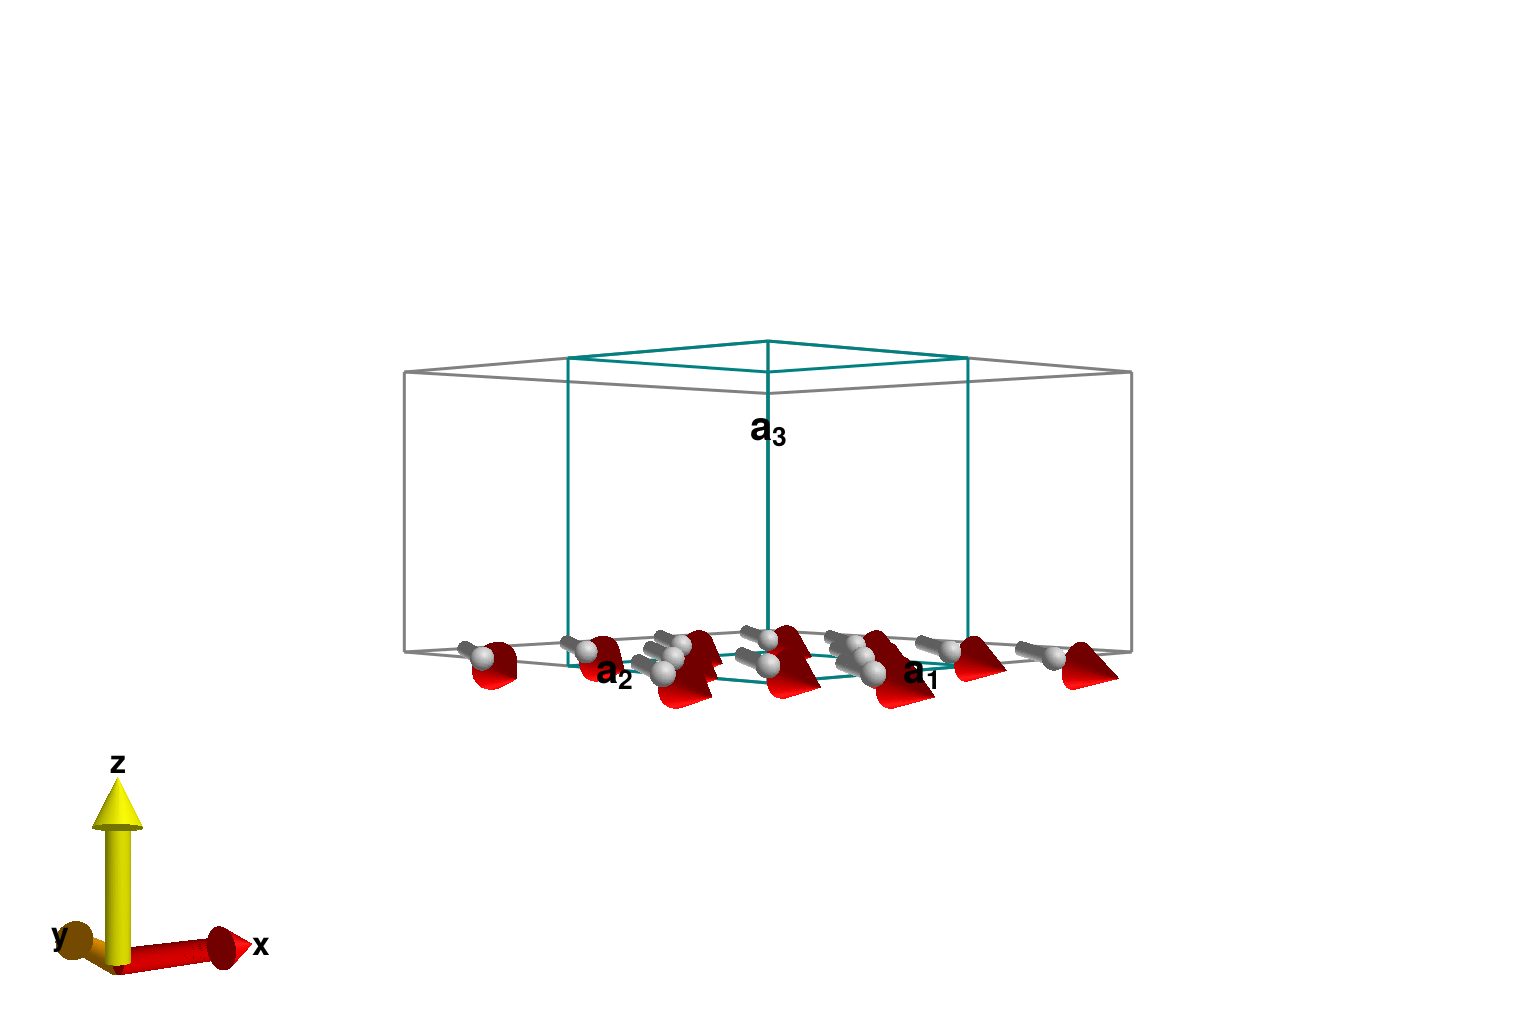

In [3]:
J1=-1.0
J2=0.1
J3a=0.00
J3b=0.17
J3c=0.0

set_exchange!(sys,J1,Bond(2, 3, [0, 0, 0]))
set_exchange!(sys,J2,Bond(2, 1, [0, 0, 0]))
set_exchange!(sys,J3a,Bond(2, 2, [1, 0, 0]))
set_exchange!(sys,J3b,Bond(1, 1,[1, 0, 0]))
set_exchange!(sys,J3c,Bond(1, 1, [0, 1, 0]))
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)

Create the LSWT object and set up a path. Obtain the dispersion and intensity bands.

In [4]:
swt=SpinWaveTheory(sys)

q_points = [[-1/2,0,0], [0,0,0], [1/2,1/2,0]]
density = 50
path, xticks = reciprocal_space_path(Cu, q_points, density);
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);


Plot the dispersion and convoluted poweder spectra. Note that on spinw, the invisible modes in the dispersion have been removed. The convoluted spectra can be made smoother by increasing the number of crystallites "n".

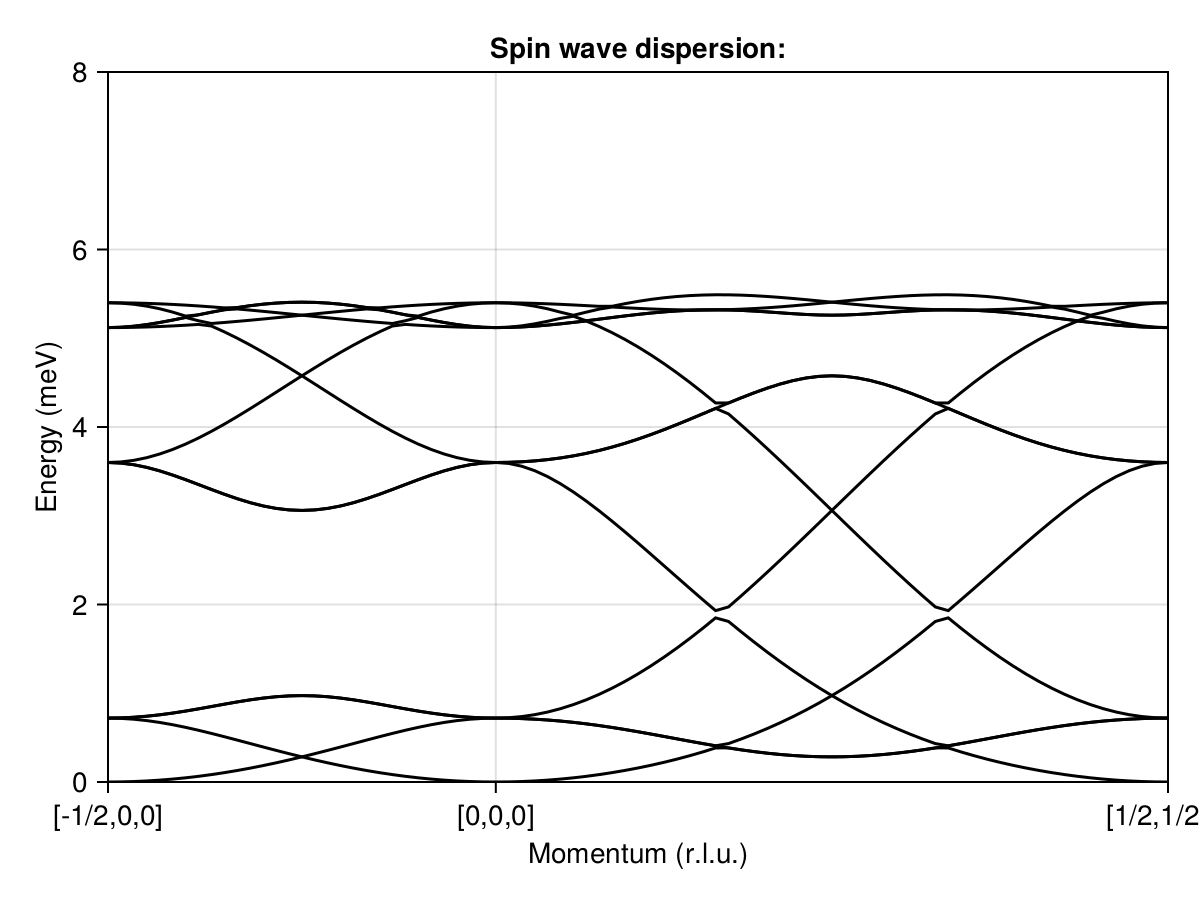

In [5]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Spin wave dispersion:", xticks)
ylims!(ax, 0.0, 8.0)
xlims!(ax, 1, size(disp, 1))
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i];color="black")
end
fig


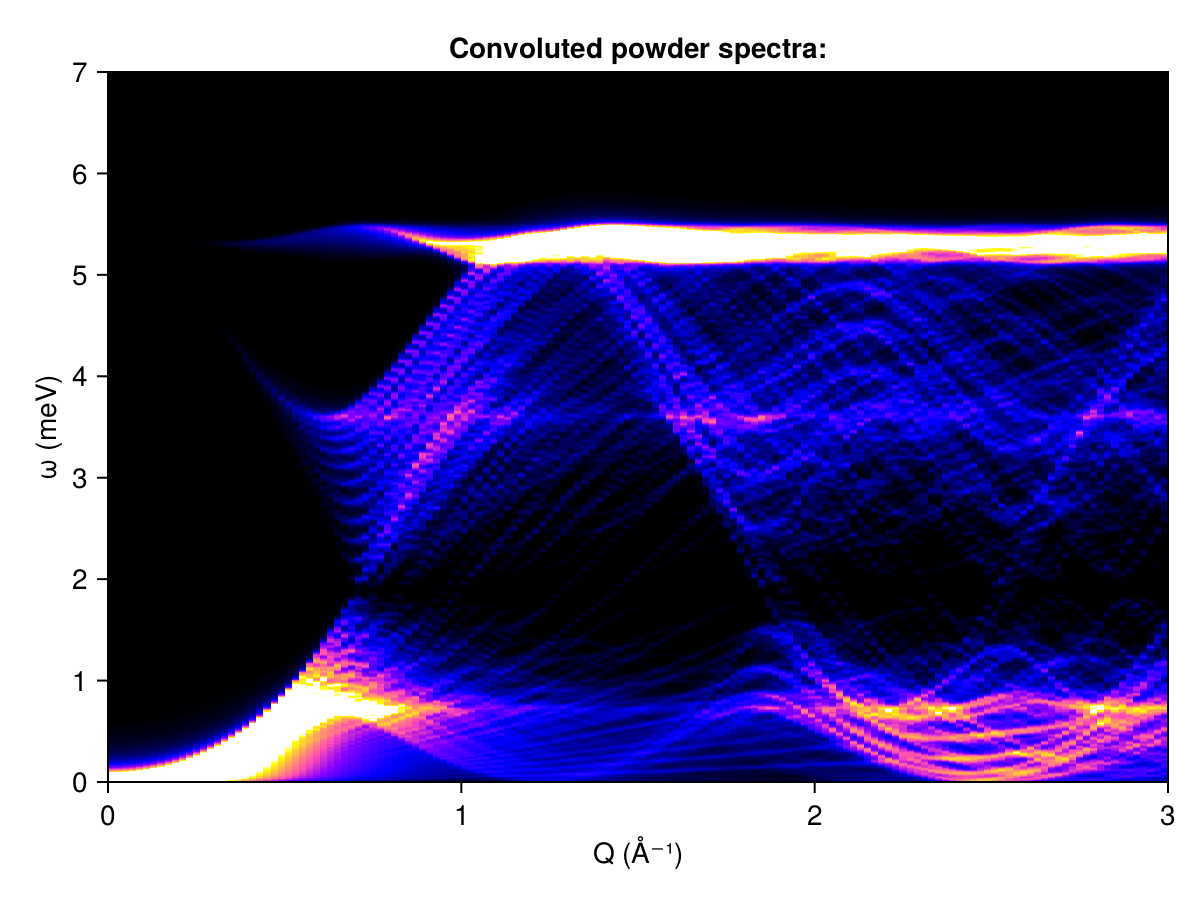

In [6]:
γ = 0.02 
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.01:10)  
is = intensities_broadened(swt, path, energies, broadened_formula);
radii = 0.01:0.02:3 
output = zeros(Float64, length(radii), length(energies))
for (i, radius) in enumerate(radii)
    n = 300
    qs = reciprocal_space_shell(Cu, radius, n)
    is1 = intensities_broadened(swt, qs, energies, broadened_formula)
    output[i, :] = sum(is1, dims=1) / size(is1, 1)
end

fig = Figure()
ax = Axis(fig[1,1]; xlabel="Q (Å⁻¹)", ylabel="ω (meV)",title="Convoluted powder spectra:")
ylims!(ax, 0.0, 7.0)
heatmap!(ax, radii, energies, output, colormap=:gnuplot2,colorrange=(0.01,0.5))
fig